# Music Genre Classification:
Using the features extracted from the audio segments contained in the GTZAN dataset, we build up the model for classification. The Classification is only limited to the classes 'Disco', 'Pop', 'Reggae', 'Rock'.

In [0]:
from google.colab import files

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import lightgbm as lgbm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Uploading the features from csv file:
The data loaded from the csv file are represented in the structured way imposed by the Dataframe representation.

In [0]:
uploaded = files.upload()

Saving features.csv to features.csv


In [0]:
features = pd.read_csv('features.csv')

# Dropping the column representing the labels
X = features.drop(['genre'], axis=1).values
# Definition of the vector of labels
y = features['genre'].values

# Splitting the data into Training Set and Test Set:
This operation builds the sets `X_train` and `y_train` which are the training set of features and their corresponding set of labels, and the sets `X_test` and `y_test` which are the testing set of features. '`random_state`' is set to a fixed value in order to make the results replicable at every new execution.

In [0]:
# The test_size will be by default the 0.25 of the dataset, while
# the labels of the corresponding sets are built over y
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=14)

# SVM: Feature Processing, Feature Selection and Classification Model
The following operations define the parameters and the pipeline to use for Support Vector Machine classification:

The parameters set are the following:

*   **'`cls__C`'**: these parameters specify different regularization factors to apply to the model to avoid overfitting.
*   **'`cls__kernel`'**: these parameters specify different kernels (Radial Basis Function kernel, Linear kernel, Sigmoidal kernel) to map the features into different feature spaces to try to improve the classification.

The pipeline defines a composite estimator applying the following transformations:


*   **'`scale`'**: standardizes features by removing the mean and scaling to unit variance.
*  **'`var_tresh`'**: it removes all features whose variance doesn’t meet some threshold.
*  **'`feature_selection`'**: in the specific, the function SelectFromModel is a meta-transformer that works after fitting and removes the features considered unimportant.
*  **'`cls`'**: Support Vector Classification is the tecnique used to perform the classification.




In [0]:
params = {
    'cls__C': [0.5, 1, 2, 5],
    'cls__kernel': ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

# Model Training:
The `GridSearchCV` exhaustively considers all parameter combinations, and when “fitting” it on a dataset all the possible combinations of parameter values are evaluated and the best combination with respect to the scoring parameter specified ('`accuracy`' in this case) is retained.

In [0]:
grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
# Performing the model training
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                            

# Model Testing and Accuracy Evaluation:
The model is evaluated on the test set extracted at the beginning from the feature dataset in performing class prediction on newly unseen data.
Accuracy scores achieved by the model both on Validation set (after the Cross Validation process) and Test set are plotted. More structured informations regarding hyper-parameters estimation and prediction performances are reported.


In [0]:
predictions = grid_svm.predict(X_test)

print("Score on training set (accuracy) = {:.4f}\n".format(grid_svm.score(X_train, y_train)))

print("Cross Validation scores (accuracy) for each set of parameters (95% confidence interval):")

means = grid_svm.cv_results_['mean_test_score']
stds = grid_svm.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, grid_svm.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("Given the parameters:")
print("C = {}".format(grid_svm.best_params_['cls__C']))
print("Kernel = {}\n".format(grid_svm.best_params_['cls__kernel']))

print("Classification Report on Test Set:")
print(classification_report(y_test, predictions, target_names=['disco','pop','reggae','rock']))
print("Score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, predictions)))

Score on training set (accuracy) = 1.0000

Cross Validation scores (accuracy) for each set of parameters (95% confidence interval):
0.760 (+/-0.105) for {'cls__C': 0.5, 'cls__kernel': 'rbf'}
0.747 (+/-0.053) for {'cls__C': 0.5, 'cls__kernel': 'linear'}
0.760 (+/-0.062) for {'cls__C': 0.5, 'cls__kernel': 'sigmoid'}
0.780 (+/-0.116) for {'cls__C': 1, 'cls__kernel': 'rbf'}
0.747 (+/-0.053) for {'cls__C': 1, 'cls__kernel': 'linear'}
0.763 (+/-0.098) for {'cls__C': 1, 'cls__kernel': 'sigmoid'}
0.793 (+/-0.109) for {'cls__C': 2, 'cls__kernel': 'rbf'}
0.747 (+/-0.053) for {'cls__C': 2, 'cls__kernel': 'linear'}
0.743 (+/-0.050) for {'cls__C': 2, 'cls__kernel': 'sigmoid'}
0.800 (+/-0.070) for {'cls__C': 5, 'cls__kernel': 'rbf'}
0.747 (+/-0.053) for {'cls__C': 5, 'cls__kernel': 'linear'}
0.723 (+/-0.058) for {'cls__C': 5, 'cls__kernel': 'sigmoid'}

Best score on validation set (accuracy) = 0.8000
Given the parameters:
C = 5
Kernel = rbf

Classification Report on Test Set:
              precision

# Confusion Matrix:
Below the definition of the function to properly plot the confusion matrix and its evaluation on the model.

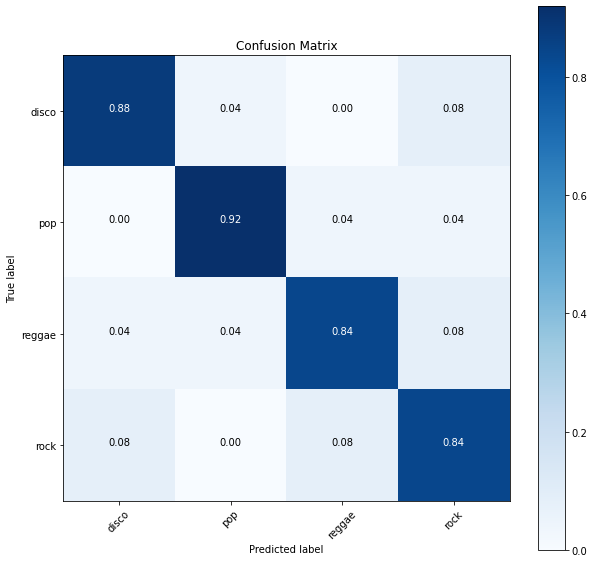

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    
    # Normalization can be applied by setting normalize=True
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Computing the confusion matrix between predictions and real labels through the
# sklearn library function
cm = confusion_matrix(y_test, predictions)
classes = ['disco', 'pop', 'reggae', 'rock']

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, classes, normalize=True)